In [49]:
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

import matplotlib.pyplot as plt
from dawnet import Inspector, op

torch.set_grad_enabled(False)

In [2]:
# get the data
model_name = "Qwen/Qwen3-4B-Base"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="mps")
tokenizer = AutoTokenizer.from_pretrained(model_name)

insp = Inspector(model)

W0913 11:57:25.141000 59107 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# op1 = op.GetOutput(output_getter=0)
insp.add(op.GetOutput(), name_regex=r"model.layers.\d+$")
print(insp)

In [117]:
def forward(insp, name, module, args, kwargs, output):
    if "hidden_states" in kwargs:
        hidden_states = kwargs["hidden_states"]
    else:
        hidden_states = args[0]
    print("="*10, name)
    print(f"input mean={hidden_states[0,-1].mean().item()} variance={hidden_states[0,-1].pow(2).mean().item()}")
    print(f"output mean={output[0,-1].mean().item()} variance={output[0,-1].pow(2).mean().item()}")
    return output

forward_op = insp.add(op.Hook(forward=forward), name_regex=r"model.layers.\d+.post_attention_layernorm$")

In [114]:
print(insp)

Inspector ops:
- [0] GetOutput @ ['model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.layers.28', 'model.layers.29', 'model.layers.30', 'model.layers.31', 'model.layers.32', 'model.layers.33', 'model.layers.34', 'model.layers.35'] (disabled)
- [1] Hook(forward=forward) @ ['model.layers.0.input_layernorm', 'model.layers.1.input_layernorm', 'model.layers.2.input_layernorm', 'model.layers.3.input_layernorm', 'model.layers.4.input_layernorm', 'model.layers.5.input_layernorm', 'model.layers.6.input_layernorm', 'model.layer

In [118]:
with insp.ctx() as state:
    text = "Then, Peter and Paul went to the meeting room. Peter gave a key to"
    input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")
    out = insp(input_ids)

========== model.layers.0.post_attention_layernorm
input mean=0.00047003309009596705 variance=0.0036225891672074795
output mean=-0.0016279409173876047 variance=0.014397205784916878
========== model.layers.1.post_attention_layernorm
input mean=0.0004514554457273334 variance=0.022681916132569313
output mean=-0.015890421345829964 variance=1.842707872390747
========== model.layers.2.post_attention_layernorm
input mean=-0.0024384609423577785 variance=0.03060626983642578
output mean=-0.027040744200348854 variance=4.09997034072876
========== model.layers.3.post_attention_layernorm
input mean=-0.0018855802481994033 variance=0.04394443705677986
output mean=-0.006651236210018396 variance=2.14355206489563
========== model.layers.4.post_attention_layernorm
input mean=-0.0014525571605190635 variance=0.0961403101682663
output mean=-0.00020776056044269353 variance=1.0552499294281006
========== model.layers.5.post_attention_layernorm
input mean=-0.001395706320181489 variance=0.1819438934326172
output 

In [389]:
text = "Then, Peter and Paul went to the meeting room. Peter gave a key to"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")

insp.begin()
out = insp(input_ids)
print(f"{out['logits'].shape=}")
print(f"{out['logits'][0,-1].argmax().cpu().item()=}")

for idx_ in range(36):
    temp_ = insp.original_model.lm_head(insp.state["output"][f"model.layers.{idx_}"])
    tok_ = temp_[0,-1].argmax().cpu().item()
    print(idx_, tok_, tokenizer.decode(tok_))

# insp.finish()

out['logits'].shape=torch.Size([1, 16, 151936])
out['logits'][0,-1].argmax().cpu().item()=6898
0 128112 landır
1 118824 发挥作用
2 111383 什么呢
3 142808 引っ
4 142808 引っ
5 142808 引っ
6 43573  smo
7 125746 처
8 135683  oran
9 32531 {o
10 88463 )o
11 55864 -piece
12 55864 -piece
13 62748 isu
14 132342 şık
15 126680 สำค
16 106984 所有人
17 106984 所有人
18 106984 所有人
19 106984 所有人
20 106984 所有人
21 79368 -letter
22 106984 所有人
23 106984 所有人
24 106984 所有人
25 106984 所有人
26 106984 所有人
27 38271  whoever
28 38271  whoever
29 38271  whoever
30 73191  unlocks
31 55342 //}


32 55342 //}


33 55342 //}


34 55342 //}


35 6898  Paul


In [10]:
print(insp.original_model)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((2560,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [14]:
insp.original_model.model.layers[10].input_layernorm.weight

Parameter containing:
tensor([-0.0119,  0.4980,  0.3438,  ...,  0.4199,  0.3789,  0.4531],
       device='mps:0', requires_grad=True)

In [22]:
insp.original_model.model.layers[29].input_layernorm.weight

Parameter containing:
tensor([0.9531, 7.5625, 8.5625,  ..., 1.6797, 1.4922, 1.6328], device='mps:0',
       requires_grad=True)

In [107]:
insp.original_model.model.norm.weight.data.norm(p=2)

tensor(141.0601, device='mps:0')

In [106]:
n_layers = len(insp.original_model.model.layers)
norm1 = []
for layer1 in range(n_layers):
    n_ = insp.original_model.model.layers[layer1].input_layernorm.weight.data.norm(p=2)
    norm1.append(round(n_.item(), 4))
print(norm1)

[1.2848, 2.1636, 3.681, 4.5045, 6.2824, 6.4433, 8.986, 12.1399, 15.5965, 15.7568, 21.576, 15.3967, 16.6882, 14.9742, 20.9327, 22.1537, 32.1289, 29.56, 31.3744, 38.5836, 35.0943, 38.4441, 51.4174, 47.6872, 55.3541, 53.0105, 65.3474, 71.6209, 69.7064, 95.3865, 116.2653, 132.1639, 163.8489, 235.6576, 238.275, 207.0505]


In [95]:
n_layers = len(insp.original_model.model.layers)
result2 = []
for layer1 in range(n_layers):
    sim = F.cosine_similarity(
        insp.original_model.model.layers[layer1].post_attention_layernorm.weight.data,
        insp.original_model.model.norm.weight.data,
        dim=0,
    )
    result2.append(round(sim.item(), 4))

RuntimeError: The size of tensor a (128) must match the size of tensor b (2560) at non-singleton dimension 0

In [90]:
print(result2)

[0.9775, 0.9551, 0.9412, 0.9665, 0.9785, 0.9828, 0.9363, 0.9764, 0.9783, 0.9712, 0.9643, 0.9613, 0.9604, 0.961, 0.9527, 0.9436, 0.9419, 0.9451, 0.9507, 0.9608, 0.9646, 0.9718, 0.9789, 0.982, 0.9834, 0.9844, 0.9854, 0.9869, 0.9879, 0.9881, 0.9898, 0.9917, 0.9936, 0.9921, 0.9523, 0.9562]


In [97]:
n_layers = len(insp.original_model.model.layers)
result3 = []
for layer1 in range(n_layers):
    sim = F.cosine_similarity(
        insp.original_model.model.layers[layer1].self_attn.q_norm.weight.data,
        insp.original_model.model.layers[layer1].self_attn.k_norm.weight.data,
        dim=0,
    )
    result3.append(sim.item())
print(result3)

[0.37740761041641235, 0.7302491664886475, 0.849428117275238, 0.9296122193336487, 0.7108964920043945, 0.570442795753479, 0.7909135818481445, 0.9320238828659058, 0.7910372018814087, 0.9289329051971436, 0.6935834884643555, 0.7758302688598633, 0.8504653573036194, 0.9458984136581421, 0.842180609703064, 0.9506731629371643, 0.8931821584701538, 0.945141613483429, 0.9127823710441589, 0.9101368188858032, 0.9619965553283691, 0.9112886786460876, 0.891165018081665, 0.8962390422821045, 0.9516381025314331, 0.8815370798110962, 0.9045844078063965, 0.897445559501648, 0.8736893534660339, 0.9065861701965332, 0.857168436050415, 0.8963944911956787, 0.8841371536254883, 0.9021483659744263, 0.8301116228103638, 0.6888176798820496]


In [100]:
n_layers = len(insp.original_model.model.layers)
result = np.zeros((n_layers, n_layers), dtype=float)
for layer1 in range(n_layers):
    for layer2 in range(layer1, n_layers):
        sim = F.cosine_similarity(
            insp.original_model.model.layers[layer1].self_attn.k_norm.weight.data,
            insp.original_model.model.layers[layer2].self_attn.k_norm.weight.data,
            dim=0,
        )
        result[layer1, layer2] = sim
        result[layer2, layer1] = sim

In [101]:
result.mean(axis=1)

array([0.49623002, 0.79373775, 0.86875457, 0.88757719, 0.77561206,
       0.80463761, 0.84195024, 0.89562478, 0.83404151, 0.88958744,
       0.81875869, 0.84781401, 0.86815292, 0.89601336, 0.85988337,
       0.89569076, 0.88056244, 0.88517132, 0.88711801, 0.8858021 ,
       0.89739927, 0.89441987, 0.87377809, 0.87626831, 0.89131211,
       0.88365508, 0.8781735 , 0.88394219, 0.88846918, 0.87181571,
       0.884975  , 0.88138799, 0.87843365, 0.86246043, 0.87730395,
       0.79373962])

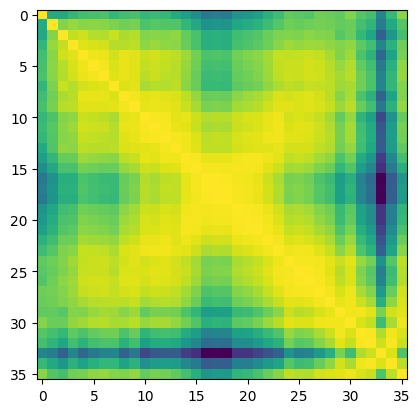

In [57]:
plt.imshow(result)

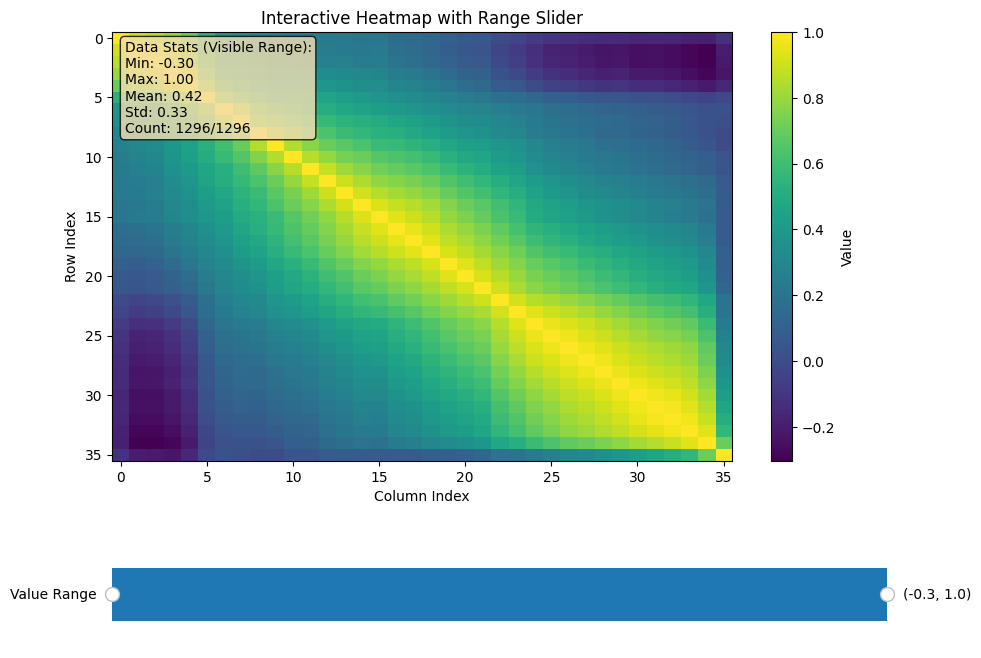

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RangeSlider
import matplotlib.patches as patches

# Create sample NxN array (replace this with your actual array)
N = 20
np.random.seed(42)  # For reproducible example
data = np.random.randn(N, N) * 10 + 50  # Random data with mean=50, std=10

class InteractiveHeatmap:
    def __init__(self, data):
        self.data = data
        self.vmin = np.min(data)
        self.vmax = np.max(data)
        
        # Create figure and subplots
        self.fig, (self.ax_heatmap, self.ax_slider) = plt.subplots(
            2, 1, figsize=(10, 8), 
            gridspec_kw={'height_ratios': [4, 1], 'hspace': 0.3}
        )
        
        # Initial heatmap
        self.im = self.ax_heatmap.imshow(
            self.data, 
            cmap='viridis', 
            vmin=self.vmin, 
            vmax=self.vmax,
            aspect='auto'
        )
        
        # Add colorbar
        self.cbar = plt.colorbar(self.im, ax=self.ax_heatmap)
        self.cbar.set_label('Value')
        
        # Set up heatmap
        self.ax_heatmap.set_title('Interactive Heatmap with Range Slider')
        self.ax_heatmap.set_xlabel('Column Index')
        self.ax_heatmap.set_ylabel('Row Index')
        
        # Create range slider
        self.range_slider = RangeSlider(
            self.ax_slider, 
            'Value Range', 
            self.vmin, 
            self.vmax,
            valinit=(self.vmin, self.vmax),
            valfmt='%.1f'
        )
        
        # Connect slider to update function
        self.range_slider.on_changed(self.update_heatmap)
        
        # Add statistics text
        self.stats_text = self.ax_heatmap.text(
            0.02, 0.98, '', 
            transform=self.ax_heatmap.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        )
        
        self.update_stats()
        
    def update_heatmap(self, val):
        """Update heatmap when slider values change"""
        vmin_new, vmax_new = self.range_slider.val
        
        # Update image display range
        self.im.set_clim(vmin_new, vmax_new)
        
        # Update colorbar
        self.cbar.update_normal(self.im)
        
        # Update statistics
        self.update_stats(vmin_new, vmax_new)
        
        # Redraw
        self.fig.canvas.draw_idle()
    
    def update_stats(self, vmin_display=None, vmax_display=None):
        """Update statistics display"""
        if vmin_display is None:
            vmin_display = self.vmin
        if vmax_display is None:
            vmax_display = self.vmax
            
        # Calculate statistics for displayed range
        mask = (self.data >= vmin_display) & (self.data <= vmax_display)
        visible_data = self.data[mask]
        
        if len(visible_data) > 0:
            stats = f"""Data Stats (Visible Range):
Min: {np.min(visible_data):.2f}
Max: {np.max(visible_data):.2f}
Mean: {np.mean(visible_data):.2f}
Std: {np.std(visible_data):.2f}
Count: {len(visible_data)}/{self.data.size}"""
        else:
            stats = "No data in selected range"
            
        self.stats_text.set_text(stats)
    
    def show(self):
        """Display the interactive plot"""
        plt.show()

# Create and display the interactive heatmap
heatmap = InteractiveHeatmap(result)
heatmap.show()

In [159]:
n_layers = len(insp.state["output"])
result = np.zeros((n_layers, n_layers), dtype=float)
for layer1 in range(n_layers):
    for layer2 in range(layer1, n_layers):
        sim = F.cosine_similarity(
            insp.original_model.model.norm(insp.state["output"][f"model.layers.{layer1}"])[0,-1],
            insp.original_model.model.norm(insp.state["output"][f"model.layers.{layer2}"])[0,-1],
            dim=0,
        )
        result[layer1, layer2] = sim
        result[layer2, layer1] = sim
print(result)

[[ 0.99999988  0.91091013  0.86808598 ... -0.18127121 -0.18959296
  -0.11029746]
 [ 0.91091013  1.          0.95857614 ... -0.2817733  -0.29761916
  -0.19830865]
 [ 0.86808598  0.95857614  0.99999988 ... -0.28531364 -0.30218732
  -0.20817715]
 ...
 [-0.18127121 -0.2817733  -0.28531364 ...  1.          0.94355839
   0.55967426]
 [-0.18959296 -0.29761916 -0.30218732 ...  0.94355839  0.99999994
   0.70479637]
 [-0.11029746 -0.19830865 -0.20817715 ...  0.55967426  0.70479637
   1.        ]]


In [164]:
with np.printoptions(suppress=True):
    print(result[35])

[-0.11029746 -0.19830865 -0.20817715 -0.22081044 -0.15727331 -0.01324367
  0.0279231   0.01454724  0.00022579  0.00146958  0.04331242  0.04060222
  0.07124151  0.08205576  0.0798437   0.07180449  0.0790761   0.07508378
  0.10023248  0.09631446  0.10899808  0.1343791   0.19506866  0.20008437
  0.23387454  0.27107063  0.30379143  0.31853473  0.35211331  0.38311607
  0.42687827  0.46408254  0.50676119  0.55967426  0.70479637  1.        ]


In [165]:
with np.printoptions(suppress=True):
    print(result[34])

[-0.18959296 -0.29761916 -0.30218732 -0.27841184 -0.20682052 -0.03860427
  0.0214318   0.02525633  0.02092374  0.04564185  0.08510002  0.09113434
  0.14807017  0.16956234  0.19413939  0.18894374  0.23441009  0.25482744
  0.29863393  0.32802379  0.35256004  0.38239652  0.47219455  0.5171864
  0.58621699  0.6364643   0.68136466  0.70452952  0.74398053  0.77934074
  0.82476097  0.85729814  0.89295369  0.94355839  0.99999994  0.70479637]


In [167]:
with np.printoptions(suppress=True):
    print(result[list(range(35)),list(range(1,36))])

[0.91091013 0.95857614 0.92247021 0.90704799 0.77669227 0.74723828
 0.83280724 0.77054977 0.84786534 0.84857243 0.86005151 0.88598031
 0.89850259 0.9107188  0.93028939 0.93774313 0.94989467 0.94633156
 0.92306846 0.93748486 0.92116588 0.90754783 0.91165364 0.93611771
 0.96139258 0.966923   0.96729028 0.96817005 0.96005917 0.96628481
 0.9706229  0.98044467 0.97113407 0.94355839 0.70479637]


In [168]:
np.arccos(result[list(range(35)),list(range(1,36))])

array([0.42531179, 0.28883576, 0.39636559, 0.43457755, 0.68139901,
       0.72689975, 0.5866366 , 0.69109307, 0.55885014, 0.55751511,
       0.5354257 , 0.48219257, 0.45445002, 0.42577527, 0.37559537,
       0.35472187, 0.31789759, 0.32910631, 0.39481311, 0.35546471,
       0.39973056, 0.43338882, 0.42350621, 0.35937245, 0.27877744,
       0.2579185 , 0.2564746 , 0.25298324, 0.28358273, 0.26040877,
       0.24299002, 0.19808786, 0.24085633, 0.33758165, 0.78866026])

In [175]:
3.14/6

0.5233333333333333

In [58]:
F.cosine_similarity(
    insp.original_model.model.layers[16].input_layernorm.weight.data,
    insp.original_model.model.layers[33].input_layernorm.weight.data,
    dim=0,
)

tensor(0.6508, device='mps:0')

In [130]:
(insp.original_model.model.layers[33].input_layernorm.weight.data
 - insp.original_model.model.layers[35].input_layernorm.weight.data).norm(p=2)

tensor(101.2175, device='mps:0')

In [144]:
insp.original_model.model.layers[30].input_layernorm.weight.shape

torch.Size([2560])

In [142]:
n_layers = len(insp.original_model.model.layers)
dists_ = np.zeros((n_layers, n_layers), dtype=float)
for layer1 in range(n_layers):
    for layer2 in range(layer1, n_layers):
        dist_ = (
            insp.original_model.model.layers[layer1].post_attention_layernorm.weight.data -
            insp.original_model.model.layers[layer2].post_attention_layernorm.weight.data
        ).norm(p=2).item()
        dists_[layer1, layer2] = dist_
        dists_[layer2, layer1] = dist_

In [139]:
insp.original_model.model.layers[10].input_layernorm.weight.data

tensor([-0.0119,  0.4980,  0.3438,  ...,  0.4199,  0.3789,  0.4531],
       device='mps:0')

In [9]:
insp.original_model.model.norm.weight

Parameter containing:
tensor([-0.0054,  2.2031,  3.6562,  ...,  2.6719,  2.7812,  2.6719],
       device='mps:0', requires_grad=True)

#### Calculate angles between subspaces

In [323]:
feats = []
for idx_ in range(30):
    feats.append(insp.original_model.model.norm(insp.state["output"][f"model.layers.{idx_}"])[0,-1].cpu().numpy())
feats = np.array(feats)
print(feats.shape)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feats2 = scaler.fit_transform(feats)
    
pca = PCA(n_components=20) # Or choose a number based on explained variance
principal_components = pca.fit_transform(feats2)
print(pca.explained_variance_ratio_.sum())

sp1 = pca.components_.copy()

(30, 2560)
0.9554178


In [318]:
feats = []
for idx_ in range(35):
    feats.append(insp.original_model.model.norm(insp.state["output"][f"model.layers.{idx_}"])[0,-1].cpu().numpy())
feats = np.array(feats)
print(feats.shape)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feats2 = scaler.fit_transform(feats)

pca = PCA(n_components=20) # Or choose a number based on explained variance
principal_components = pca.fit_transform(feats2)
print(pca.explained_variance_ratio_.sum())

sp2 = pca.components_.copy()

(35, 2560)
0.94264525


In [324]:
from scipy.linalg import subspace_angles
angles = subspace_angles(sp1.T, sp2.T)
print(angles)

[1.5701983  0.7096211  0.12094881 0.0915257  0.08574132 0.08340506
 0.07994921 0.07426017 0.07266936 0.07256433 0.06993954 0.06855087
 0.06672674 0.0664772  0.0654998  0.06340352 0.06278454 0.05968149
 0.05925022 0.05760342]


In [331]:
math.pi / 2

1.5707963267948966

In [325]:
np.rad2deg(0.7)

40.10704565915762

In [334]:
for n_components in range(2, 30):
    feats = []
    for idx_ in range(35):
        feats.append(insp.original_model.model.norm(insp.state["output"][f"model.layers.{idx_}"])[0,4].cpu().numpy())
    feats = np.array(feats)
    
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    feats2 = scaler.fit_transform(feats)
    
    pca = PCA(n_components=n_components) # Or choose a number based on explained variance
    principal_components = pca.fit_transform(feats2)
    
    sp1 = pca.components_.copy()
    
    feats = []
    for idx_ in range(35):
        feats.append(insp.original_model.model.norm(insp.state["output"][f"model.layers.{idx_}"])[0,-1].cpu().numpy())
    feats = np.array(feats)
    
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    feats2 = scaler.fit_transform(feats)
    
    pca = PCA(n_components=n_components) # Or choose a number based on explained variance
    principal_components = pca.fit_transform(feats2)
    
    sp2 = pca.components_.copy()
    from scipy.linalg import subspace_angles
    angles = subspace_angles(sp1.T, sp2.T)
    print(n_components, angles[:5])

2 [1.4972963 1.4819475]
3 [1.4967122 1.4808578 1.4675769]
4 [1.5151774 1.4934663 1.477533  1.4634097]
5 [1.5576086 1.5034355 1.4847064 1.4634609 1.4509339]
6 [1.5598404 1.5406103 1.5033396 1.4812379 1.4551792]
7 [1.5616295 1.5526959 1.5104898 1.4933416 1.4663322]
8 [1.5583779 1.557063  1.5211225 1.498175  1.4903858]
9 [1.5680822 1.5540227 1.5326146 1.5145661 1.493237 ]
10 [1.5687792 1.5643141 1.5386552 1.5222837 1.5067687]
11 [1.5691979 1.5544343 1.539065  1.5243421 1.5065142]
12 [1.5674661 1.5542809 1.5394475 1.5191007 1.5110165]
13 [1.5669352 1.5558335 1.5495204 1.5309653 1.5134331]
14 [1.5664358 1.5638694 1.5365857 1.5352659 1.5301843]
15 [1.569028  1.5596539 1.5379235 1.5323919 1.5249671]
16 [1.5677824 1.5606778 1.5474075 1.5365055 1.5226672]
17 [1.5706062 1.5650561 1.5528833 1.537626  1.5260627]
18 [1.5695822 1.5615866 1.5517181 1.541877  1.5366576]
19 [1.570328  1.5663186 1.5595913 1.545988  1.5302603]
20 [1.5704486 1.5652826 1.5639477 1.5478494 1.5382453]
21 [1.5683484 1.5657974

#### Find subspace

In [285]:
feats = []
for idx_ in range(31):
    feats.append(insp.original_model.model.norm(insp.state["output"][f"model.layers.{idx_}"])[0,-1].cpu().numpy())
feats = np.array(feats)
print(feats.shape)

(31, 2560)


In [286]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feats2 = scaler.fit_transform(feats)

In [287]:
pca = PCA(n_components=20) # Or choose a number based on explained variance
principal_components = pca.fit_transform(feats2)
print(pca.explained_variance_ratio_.sum())

0.9525522


In [288]:
sp2 = pca.components_.copy()

In [276]:
sp1 = pca.components_.copy()
sp2 = pca.components_.copy()

In [289]:
from scipy.linalg import subspace_angles
angles = subspace_angles(sp1.T, sp2.T)
print(angles)

[1.5499251  1.2901092  0.26039892 0.11953447 0.11512205 0.11139838
 0.10338746 0.10116769 0.09480856 0.09308584 0.08922872 0.08847127
 0.08746225 0.0858427  0.08478649 0.08316524 0.0799624  0.07842709
 0.07389588 0.07362331]


[1.5625027  1.4648252  0.49160165 0.13001321 0.12657177 0.12256716
 0.11771534 0.10988118 0.10445479 0.10318199 0.1013071  0.09803578
 0.09593473 0.09525166 0.0947127  0.09280757 0.08862065 0.08736188
 0.08268309 0.08242504]


In [281]:
print(sp1.shape, sp2.shape)

(20, 2560) (20, 2560)


In [270]:
principal_components.shape

(36, 20)

In [241]:
from numpy import dot
from numpy.linalg import norm

# cos_sim = dot(a, b)/(norm(a)*norm(b))


In [242]:
n_layers = feats.shape[0]
result = np.zeros((n_layers, n_layers), dtype=float)
for layer1 in range(n_layers):
    for layer2 in range(layer1, n_layers):
        sim = dot(feats[layer1], feats[layer2]) / (norm(feats[layer1]) * norm(feats[layer2]))
        result[layer1, layer2] = sim
        result[layer2, layer1] = sim
print(result)

[[ 1.          0.91090995  0.86808604 ... -0.18127117 -0.18959315
  -0.1102975 ]
 [ 0.91090995  1.00000012  0.95857614 ... -0.28177321 -0.29761913
  -0.19830845]
 [ 0.86808604  0.95857614  1.         ... -0.28531381 -0.30218735
  -0.2081773 ]
 ...
 [-0.18127117 -0.28177321 -0.28531381 ...  0.99999994  0.94355822
   0.55967432]
 [-0.18959315 -0.29761913 -0.30218735 ...  0.94355822  1.00000012
   0.70479655]
 [-0.1102975  -0.19830845 -0.2081773  ...  0.55967432  0.70479655
   1.        ]]


In [245]:
n_layers = principal_components.shape[0]
result_pc = np.zeros((n_layers, n_layers), dtype=float)
for layer1 in range(n_layers):
    for layer2 in range(layer1, n_layers):
        sim = dot(principal_components[layer1], principal_components[layer2]) / (norm(principal_components[layer1]) * norm(principal_components[layer2]))
        result_pc[layer1, layer2] = sim
        result_pc[layer2, layer1] = sim
print(result_pc)

[[ 1.          0.83243316  0.66678149 ... -0.06993097 -0.04941262
  -0.01310529]
 [ 0.83243316  1.          0.94648445 ... -0.14317943 -0.13517314
  -0.05651401]
 [ 0.66678149  0.94648445  1.00000012 ... -0.15431394 -0.14271675
  -0.05001436]
 ...
 [-0.06993097 -0.14317943 -0.15431394 ...  1.00000012  0.95225072
   0.38795456]
 [-0.04941262 -0.13517314 -0.14271675 ...  0.95225072  0.99999994
   0.59514987]
 [-0.01310529 -0.05651401 -0.05001436 ...  0.38795456  0.59514987
   1.        ]]


In [248]:
result_pc[list(range(35)),list(range(1,36))]

array([0.83243316, 0.94648445, 0.8111158 , 0.86304522, 0.52956909,
       0.44790211, 0.61876202, 0.45945379, 0.61554438, 0.57582152,
       0.5697841 , 0.64759666, 0.70561051, 0.77281886, 0.88513899,
       0.87693316, 0.93588501, 0.92113602, 0.7845574 , 0.90325534,
       0.83386487, 0.80985129, 0.75345474, 0.86990631, 0.94624263,
       0.96185505, 0.94313729, 0.95004267, 0.9291656 , 0.9589597 ,
       0.96522373, 0.98060036, 0.96892118, 0.95225072, 0.59514987])

In [266]:
principal_components.shape

(36, 20)

In [250]:
n_layers = principal_components.shape[0]
result_pc = np.zeros((n_layers, n_layers), dtype=float)
for layer1 in range(n_layers):
    for layer2 in range(layer1, n_layers):
        sim = dot(principal_components[layer1], principal_components[layer2]) / (norm(principal_components[layer1]) * norm(principal_components[layer2]))
        result_pc[layer1, layer2] = sim
        result_pc[layer2, layer1] = sim
print(result_pc)
result_pc[list(range(35)),list(range(1,36))]

[[ 1.          0.92306691  0.86155653 ... -0.38018754 -0.33475116
  -0.15839766]
 [ 0.92306691  1.00000012  0.98476106 ... -0.50604987 -0.46679103
  -0.25392553]
 [ 0.86155653  0.98476106  1.         ... -0.53118396 -0.49121746
  -0.27658853]
 ...
 [-0.38018754 -0.50604987 -0.53118396 ...  0.99999988  0.96202797
   0.53869385]
 [-0.33475116 -0.46679103 -0.49121746 ...  0.96202797  1.
   0.70687222]
 [-0.15839766 -0.25392553 -0.27658853 ...  0.53869385  0.70687222
   1.00000012]]


array([0.92306691, 0.98476106, 0.94142556, 0.93856257, 0.7373805 ,
       0.64089531, 0.74278051, 0.62558532, 0.73889822, 0.71763778,
       0.72380209, 0.77802473, 0.81245267, 0.86780155, 0.92220068,
       0.92243308, 0.95780271, 0.94482446, 0.86482108, 0.9418124 ,
       0.88395548, 0.87094843, 0.8510682 , 0.92487448, 0.97450566,
       0.98064184, 0.9830758 , 0.98303479, 0.97126627, 0.98214549,
       0.98639327, 0.99166465, 0.98420763, 0.96202797, 0.70687222])

In [ ]:
n_layers = feats2.shape[0]
result_feats2 = np.zeros((n_layers, n_layers), dtype=float)
for layer1 in range(n_layers):
    for layer2 in range(layer1, n_layers):
        sim = dot(feats2[layer1], feats2[layer2]) / (norm(feats2[layer1]) * norm(feats2[layer2]))
        result_feats2[layer1, layer2] = sim
        result_feats2[layer2, layer1] = sim
print(result_feats2)

In [234]:
components = pca.components_[:10]

In [236]:
components.shape

(10, 2560)

In [227]:
print(principal_components)

[[-34.260136  -33.25755  ]
 [-37.919827  -33.46328  ]
 [-37.580124  -32.511433 ]
 [-36.444107  -27.700727 ]
 [-30.311575  -21.465918 ]
 [-30.540823  -11.880679 ]
 [-31.30472    -0.6738793]
 [-29.136883    5.5576506]
 [-29.080177   18.107313 ]
 [-23.57191    23.534634 ]
 [-18.77205    27.194956 ]
 [-13.766833   30.98036  ]
 [ -9.099713   29.478922 ]
 [ -5.8638697  30.813002 ]
 [ -1.1699358  28.672132 ]
 [  1.2918172  29.136251 ]
 [  4.123912   24.920567 ]
 [  6.2429776  23.519056 ]
 [  8.289223   22.77015  ]
 [ 11.059762   19.852028 ]
 [ 13.892605   17.179386 ]
 [ 15.541436   13.792016 ]
 [ 18.476706    8.379187 ]
 [ 21.494087    3.3539033]
 [ 20.149307   -2.6728663]
 [ 21.557299   -5.4164276]
 [ 22.640566   -8.341194 ]
 [ 23.449139  -11.265541 ]
 [ 24.169342  -13.908571 ]
 [ 24.638538  -17.4098   ]
 [ 23.972948  -19.605827 ]
 [ 22.936758  -21.211584 ]
 [ 22.18882   -21.910997 ]
 [ 21.43655   -22.251753 ]
 [ 20.72675   -22.952467 ]
 [ 20.544115  -29.341043 ]]


In [214]:
principal_components

array([[-3.42603302e+01, -3.32573929e+01,  2.30304317e+01,
         8.40780354e+00,  1.17771511e+01,  8.35749912e+00,
        -9.48877430e+00,  1.54554300e+01,  1.06690121e+01,
        -8.83304787e+00,  1.72950573e+01,  3.64982700e+00,
        -6.50350714e+00,  3.57950544e+00, -7.81907988e+00,
         1.28711596e+01, -7.88884544e+00, -3.49150777e+00,
        -1.93555522e+00, -2.19038820e+00],
       [-3.79200363e+01, -3.34631042e+01,  2.45898838e+01,
         4.97092772e+00,  1.14248810e+01,  6.23241234e+00,
        -5.70426607e+00,  1.16711588e+01,  5.21361446e+00,
        -3.54923487e+00,  5.75992107e-01, -6.72965646e-01,
         2.82197380e+00, -2.09794903e+00,  5.51036644e+00,
        -6.59741402e+00,  4.42485189e+00,  1.99031842e+00,
         1.01244223e+00,  6.48051834e+00],
       [-3.75803261e+01, -3.25112801e+01,  2.24340801e+01,
         2.73732114e+00,  8.39443588e+00,  4.91945601e+00,
        -2.19310594e+00,  4.52611399e+00, -1.37277472e+00,
         2.61391401e+00, -8.8

In [263]:
target_emb = insp.original_model.model.embed_tokens(torch.tensor([[6898]]).to("mps"))[0,0]

In [265]:
sim_with_target_emb = []
for idx_ in range(36):
    sim = F.cosine_similarity(
        insp.original_model.model.norm(insp.state["output"][f"model.layers.{idx_}"])[0,-1],
        target_emb,
        dim=0,
    ).item()
    sim_with_target_emb.append(round(sim, 6))

print(sim_with_target_emb)

[0.008301, 0.007219, -0.001406, -0.001768, -0.003834, -0.013823, -0.015901, 0.000114, -0.016024, -0.02732, -0.020827, -0.012097, -0.008079, -0.00629, -0.015922, -0.024228, -0.024061, -0.026729, -0.016133, -0.017991, -0.012718, -0.00917, -0.010818, -0.003442, -0.001721, -0.019233, -0.001728, 0.007862, 0.007102, 0.038469, 0.061519, 0.14095, 0.148922, 0.139513, 0.128888, 0.133806]


In [257]:
text

'Then, Peter and Paul went to the meeting room. Peter gave a key to'

In [256]:
input_ids

tensor([[12209,    11, 11044,   323,  6898,  3937,   311,   279,  6438,  3054,
            13, 11044,  6551,   264,  1376,   311]], device='mps:0')

In [338]:
2 ** 32

4294967296

In [381]:
insp.enable(insp.ops[0])

In [387]:
insp.add(op.GetInput(), name_regex="^model.layers.25.mlp$")

In [388]:
print(insp)

Inspector ops:
- [0] GetOutput @ ['model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.layers.28', 'model.layers.29', 'model.layers.30', 'model.layers.31', 'model.layers.32', 'model.layers.33', 'model.layers.34', 'model.layers.35']
- [1] GetInput @ ['model.layers.25.mlp']


In [251]:
print(insp.original_model)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((2560,), eps=1e-06)
        (post_attention_layernorm): Qwe

#### Find the similarity between mlp layers

In [348]:
xyz = torch.rand((2560, 1)).to("mps")

In [350]:
a = insp.original_model.model.layers[34].mlp.gate_proj.weight @ xyz

In [352]:
b = insp.original_model.model.layers[35].mlp.gate_proj.weight @ xyz

In [355]:
(a.T @ b) / (a.norm() * b.norm())

tensor([[0.0049]], device='mps:0')

In [368]:
for idx in range(10):
    xyz = torch.rand((9728, 1)).to("mps")
    a = insp.original_model.model.layers[34].mlp.down_proj.weight @ xyz
    b = insp.original_model.model.layers[35].mlp.down_proj.weight @ xyz
    print((a.T @ b) / (a.norm() * b.norm()))

tensor([[0.0080]], device='mps:0')
tensor([[0.0316]], device='mps:0')
tensor([[0.0128]], device='mps:0')
tensor([[0.0313]], device='mps:0')
tensor([[-0.0119]], device='mps:0')
tensor([[0.0123]], device='mps:0')
tensor([[-0.0008]], device='mps:0')
tensor([[0.0192]], device='mps:0')
tensor([[-0.0095]], device='mps:0')
tensor([[0.0323]], device='mps:0')


In [396]:
insp.state['input']['model.layers.25.mlp'][0][0].shape

torch.Size([1, 16, 2560])

In [397]:
for idx in range(35):
    re_ = []
    for _ in range(10):
        # xyz = torch.rand((1, 2560)).to("mps")
        xyz = insp.state['input']['model.layers.25.mlp'][0][0][0,0:1]
        a = insp.original_model.model.layers[idx].mlp(xyz)
        b = insp.original_model.model.layers[idx+1].mlp(xyz)
        re_.append(((a @ b.T) / (a.norm() * b.norm())).item())
    print(f"{idx} vs {idx+1}", sum(re_) / len(re_))

0 vs 1 -0.037774112075567245
1 vs 2 0.02028830163180828
2 vs 3 0.21182571351528168
3 vs 4 0.06625784933567047
4 vs 5 0.06294630467891693
5 vs 6 0.030316269025206566
6 vs 7 0.04131510481238365
7 vs 8 0.3534470796585083
8 vs 9 0.33377352356910706
9 vs 10 0.43744930624961853
10 vs 11 0.41559967398643494
11 vs 12 0.47613781690597534
12 vs 13 0.3432631194591522
13 vs 14 0.450574666261673
14 vs 15 0.4880061745643616
15 vs 16 0.31718263030052185
16 vs 17 0.3473717272281647
17 vs 18 0.535580039024353
18 vs 19 0.31513240933418274
19 vs 20 0.35391998291015625
20 vs 21 0.403085857629776
21 vs 22 0.41332072019577026
22 vs 23 0.3066399395465851
23 vs 24 0.31505724787712097
24 vs 25 0.35401779413223267
25 vs 26 0.37211868166923523
26 vs 27 0.3685857057571411
27 vs 28 0.3347049355506897
28 vs 29 0.3262803256511688
29 vs 30 0.33122825622558594
30 vs 31 0.4557175934314728
31 vs 32 0.5114231109619141
32 vs 33 0.5802591443061829
33 vs 34 0.6215831637382507
34 vs 35 0.8922055959701538


In [418]:
val_ = [0, 0.25, 0.5, 0.7, 0.9, 0.95, 0.99]
for e_ in val_:
    rad_ = np.arccos(e_)
    dec = np.rad2deg(rad_)
    print(f"cosine_sim={e_: <4} rad={np.round(rad_, 4): <6}  deg={np.round(dec, 4)}")

cosine_sim=0    rad=1.5708  deg=90.0
cosine_sim=0.25 rad=1.3181  deg=75.5225
cosine_sim=0.5  rad=1.0472  deg=60.0
cosine_sim=0.7  rad=0.7954  deg=45.573
cosine_sim=0.9  rad=0.451   deg=25.8419
cosine_sim=0.95 rad=0.3176  deg=18.1949
cosine_sim=0.99 rad=0.1415  deg=8.1096


In [422]:
x_ = np.arange(101) / 100
rad_ = np.arccos(x_)
deg_ = np.rad2deg(rad_)

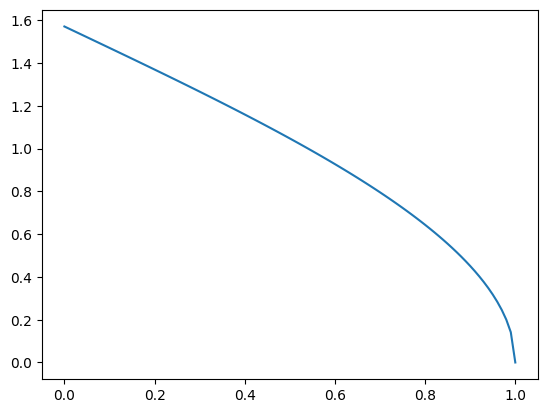

In [423]:
plt.plot(x_, rad_)

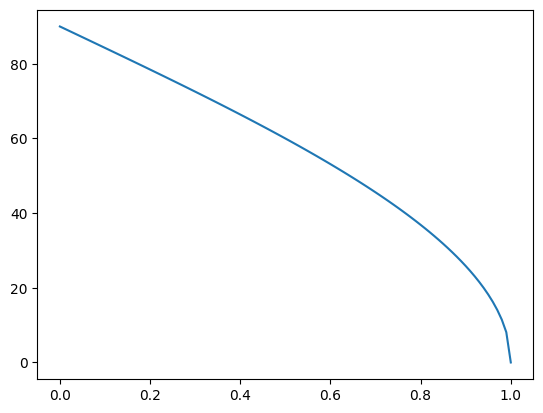

In [424]:
plt.plot(x_, deg_)

In [428]:
for a_, b_ in zip(x_, rad_):
    print(a_, b_)

0.0 1.5707963267948966
0.01 1.5607961601207294
0.02 1.5507949932215062
0.03 1.5407918249714196
0.04 1.5307856524409076
0.05 1.5207754699891265
0.06 1.5107602683496182
0.07 1.5007390337068462
0.08 1.4907107467612375
0.09 1.4806743817803012
0.1 1.4706289056333368
0.11 1.46057327680715
0.12 1.4505064444001086
0.13 1.440427347091751
0.14 1.4303349120850408
0.15 1.4202280540182106
0.16 1.410105673842986
0.17 1.399966657665792
0.18 1.3898098755483488
0.19 1.379634180263837
0.2 1.3694384060045657
0.21 1.359221367036801
0.22 1.3489818562981022
0.23 1.3387186439321834
0.24 1.3284304757559333
0.25 1.318116071652818
0.26 1.3077741238864276
0.27 1.2974032953274233
0.28 1.2870022175865687
0.29 1.276569489045914
0.3 1.266103672779499
0.31 1.2556032943541722
0.32 1.2450668395002664
0.33 1.234492751640916
0.34 1.2238794292677349
0.35 1.2132252231493863
0.36 1.2025284333582567
0.37 1.1917873060989457
0.38 1.181000030320636
0.39 1.1701647340935246
0.4 1.1592794807274085
0.41 1.148342264608141
0.42 1.137

In [357]:
a.norm(), b.norm()

(tensor(70.1799, device='mps:0'), tensor(74.1899, device='mps:0'))

In [356]:
F.cosine_similarity(a, b, dim=0)

tensor([0.0049], device='mps:0')

In [347]:
insp.original_model.model.layers[34].mlp.gate_proj.weight.shape

torch.Size([9728, 2560])

In [431]:
U1, S1, Vt1 = np.linalg.svd(insp.original_model.model.layers[34].mlp.gate_proj.weight.data.cpu().numpy(), full_matrices=False)
# U2, S2, Vt2 = np.linalg.svd(B, full_matrices=False)

In [432]:
U2, S2, Vt2 = np.linalg.svd(insp.original_model.model.layers[35].mlp.gate_proj.weight.data.cpu().numpy(), full_matrices=False)

In [433]:
print(U1.shape, S1.shape, Vt1.shape)

(9728, 2560) (2560,) (2560, 2560)


In [444]:
Vt1

array([[-6.1119447e-04,  8.7027766e-02,  7.7870704e-02, ...,
         7.6399501e-03,  7.2626970e-03,  7.4464921e-03],
       [-2.3082055e-03, -9.4833873e-02, -8.8188127e-02, ...,
         1.0553736e-02,  1.1300260e-02,  1.5225286e-02],
       [ 1.9452485e-04, -6.8721585e-02, -8.6178310e-02, ...,
         1.1801096e-02, -7.1461704e-03, -1.9113282e-02],
       ...,
       [-8.4328270e-03, -2.2638973e-02,  2.1090990e-01, ...,
        -8.8789314e-03,  8.0954014e-05, -5.2037821e-03],
       [-9.3806463e-01, -4.7737799e-04,  2.4916802e-03, ...,
        -7.5391127e-04,  1.7491991e-03,  1.5201378e-03],
       [ 3.3445007e-01,  2.1101516e-03, -1.5174903e-03, ...,
        -5.8968301e-04, -3.0260193e-04, -1.7123228e-03]], dtype=float32)

In [445]:
Vt2

array([[ 4.1642264e-03,  5.7216339e-02,  3.3489387e-02, ...,
         9.8872688e-03,  1.0903661e-02,  7.0416965e-03],
       [ 3.3042912e-04, -7.6319478e-02, -7.2045811e-02, ...,
         2.3281528e-02,  7.8027282e-04,  1.2247216e-02],
       [-4.5596603e-03,  6.8863584e-03,  5.3621914e-02, ...,
         1.4182622e-02,  2.1078588e-02, -5.4734796e-03],
       ...,
       [ 6.8735376e-02,  2.5359629e-02,  1.2763122e-02, ...,
        -6.4849667e-03,  7.0910086e-03, -2.0527032e-03],
       [-6.1609411e-01,  2.3774537e-03,  1.2290555e-02, ...,
        -1.1681376e-03, -9.9599233e-04, -3.7045926e-03],
       [ 7.4435574e-01,  2.4797670e-03, -2.9299725e-03, ...,
         1.3344926e-03,  1.3677139e-03,  1.0346984e-03]], dtype=float32)

In [434]:
singular_value_diff = np.linalg.norm(S1 - S2)

In [436]:
relative_diff = singular_value_diff / np.linalg.norm(S1)
print(relative_diff)

0.060804598


array([11.27077   ,  8.776812  ,  6.5433497 , ...,  0.58547616,
        0.25046018,  0.22297743], dtype=float32)

In [438]:
S2

array([14.606565  , 10.793458  ,  7.7160983 , ...,  0.4397557 ,
        0.28744927,  0.18308681], dtype=float32)

In [452]:
for idx in range(35):
    U1, S1, Vt1 = np.linalg.svd(insp.original_model.model.layers[idx].self_attn.o_proj.weight.data.cpu().numpy(), full_matrices=False)
    U2, S2, Vt2 = np.linalg.svd(insp.original_model.model.layers[idx+1].self_attn.o_proj.weight.data.cpu().numpy(), full_matrices=False)
    singular_value_diff = np.linalg.norm(S1 - S2)
    relative_diff = singular_value_diff / np.linalg.norm(S1)
    print(f"{idx} vs {idx+1}", relative_diff)

0 vs 1 0.12870942
1 vs 2 0.032045517
2 vs 3 0.011043633
3 vs 4 0.051953338
4 vs 5 0.043641638
5 vs 6 0.08342052
6 vs 7 0.078719825
7 vs 8 0.04328079
8 vs 9 0.052168716
9 vs 10 0.041457735
10 vs 11 0.028734922
11 vs 12 0.027467772
12 vs 13 0.036599748
13 vs 14 0.053067233
14 vs 15 0.0634441
15 vs 16 0.03482278
16 vs 17 0.03197266
17 vs 18 0.05072704
18 vs 19 0.0393932
19 vs 20 0.031850055
20 vs 21 0.028008508
21 vs 22 0.06376796
22 vs 23 0.07683298
23 vs 24 0.10002769
24 vs 25 0.12020816
25 vs 26 0.02653692
26 vs 27 0.02678293
27 vs 28 0.01548445
28 vs 29 0.044783168
29 vs 30 0.05404256
30 vs 31 0.03469663
31 vs 32 0.028806716
32 vs 33 0.051110588
33 vs 34 0.071668774
34 vs 35 0.05988615


In [345]:
insp.original_model.model.layers[35].mlp.gate_proj.weight

Parameter containing:
tensor([[-0.0056, -0.0544,  0.0064,  ..., -0.0305, -0.0109,  0.0005],
        [-0.0049, -0.0099,  0.0283,  ...,  0.0035, -0.0233,  0.0156],
        [-0.0111, -0.0082, -0.0129,  ..., -0.0076, -0.0378,  0.0027],
        ...,
        [ 0.0056,  0.0183, -0.0140,  ..., -0.0076, -0.0337, -0.0179],
        [ 0.0016,  0.0278,  0.0045,  ..., -0.0178, -0.0076,  0.0330],
        [-0.0006,  0.0303,  0.0186,  ..., -0.0243, -0.0175, -0.0134]],
       device='mps:0', requires_grad=True)

In [346]:
insp.original_model.model.layers[33].mlp.gate_proj.weight

Parameter containing:
tensor([[ 7.0496e-03, -2.5635e-02,  5.7068e-03,  ...,  2.1729e-02,
          2.1729e-02,  2.1210e-03],
        [ 6.4850e-04, -2.6733e-02, -2.7466e-02,  ...,  9.2163e-03,
          1.5182e-03,  5.9204e-03],
        [ 2.9602e-03,  1.1169e-02,  8.5449e-03,  ...,  5.1575e-03,
         -4.8065e-04, -2.0447e-03],
        ...,
        [ 3.7689e-03, -1.1492e-04, -9.0942e-03,  ..., -2.2461e-02,
         -1.3306e-02,  1.4282e-02],
        [-5.3101e-03,  5.4321e-03, -1.1414e-02,  ..., -2.4292e-02,
         -3.5156e-02, -2.9785e-02],
        [ 2.7657e-05,  1.9684e-03, -3.1982e-02,  ...,  1.6846e-02,
         -2.5391e-02, -1.3428e-03]], device='mps:0', requires_grad=True)

In [429]:
insp.original_model.model.layers[33].mlp.gate_proj.weight.shape

torch.Size([9728, 2560])

In [151]:
text = "Then, Peter and Paul went to the meeting room. Peter gave a key to"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")

insp.begin()
out = insp(input_ids)
print(f"{out['logits'].shape=}")
print(f"{out['logits'][0,-1].argmax().cpu().item()=}")

for idx_ in range(36):
    temp_ = insp.original_model.lm_head(insp.original_model.model.norm(insp.state["output"][f"model.layers.{idx_}"]))
    tok_ = temp_[0,-1].argmax().cpu().item()
    print(idx_, tok_, tokenizer.decode(tok_))
# insp.finish()

out['logits'].shape=torch.Size([1, 16, 151936])
out['logits'][0,-1].argmax().cpu().item()=6898
0 128112 landır
1 103958 的地方
2 11390 án
3 114568 的概率
4 135536  таким
5 42798 onces
6 125746 처
7 125746 처
8 89012 给
9 124009 ما
10 124009 ما
11 55864 -piece
12 55864 -piece
13 62748 isu
14 132342 şık
15 9666  pieces
16 9666  pieces
17 9666  pieces
18 9666  pieces
19 9666  pieces
20 9666  pieces
21 1449  every
22 1449  every
23 1449  every
24 1817  each
25 279  the
26 1817  each
27 279  the
28 1817  each
29 1817  each
30 1817  each
31 6898  Paul
32 6898  Paul
33 6898  Paul
34 6898  Paul
35 6898  Paul


## Use different weights

In [478]:
insp.model.model.layers[4]._forward_hooks[129]._name

'model.layers.4'

In [152]:
insp.state["output"].keys()

dict_keys(['model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.layers.28', 'model.layers.29', 'model.layers.30', 'model.layers.31', 'model.layers.32', 'model.layers.33', 'model.layers.34', 'model.layers.35'])

In [45]:
tokenizer.decode(temp[0,-1].argmax())

' Paul'

In [2]:
# get the data
model_name2 = "openai/gpt-oss-120b"
model2 = AutoModelForCausalLM.from_pretrained(model_name2, device_map="mps")
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)

insp2 = Inspector(model2)

W0912 19:09:05.710000 74109 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Using MXFP4 quantized models requires a GPU, we will default to dequantizing the model to bf16


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/4.12G [00:00<?, ?B/s]

model-00000-of-00014.safetensors:   0%|          | 0.00/4.63G [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/4.63G [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/4.06G [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/4.12G [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/4.12G [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/4.63G [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/4.63G [00:00<?, ?B/s]

{"timestamp":"2025-09-12T12:23:11.403993Z","level":"WARN","fields":{"message":"Reqwest(reqwest::Error { kind: Request, source: hyper_util::client::legacy::Error(SendRequest, hyper::Error(Io, Os { code: 54, kind: ConnectionReset, message: \"Connection reset by peer\" })) }). Retrying..."},"filename":"/Users/runner/work/xet-core/xet-core/cas_client/src/http_client.rs","line_number":242}
{"timestamp":"2025-09-12T12:23:11.404039Z","level":"WARN","fields":{"message":"Retry attempt #0. Sleeping 1.000102616s before the next attempt"},"filename":"/Users/runner/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/reqwest-retry-0.7.0/src/middleware.rs","line_number":171}


model-00008-of-00014.safetensors:   0%|          | 0.00/4.63G [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/4.63G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/4.12G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/4.06G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/4.63G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/4.12G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [45]:
text = "Finish this sentence: Then, Peter and Paul went to the meeting room. Peter gave a key to"
tokenizer2.apply_chat_template([{"role":"system","content":"Reasoning: low"},{"role":"user","content":text}], return_tensors="pt", add_generation_prompt=True, tokenize=False)

'<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.\nKnowledge cutoff: 2024-06\nCurrent date: 2025-09-13\n\nReasoning: medium\n\n# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>developer<|message|># Instructions\n\nReasoning: low\n\n<|end|><|start|>user<|message|>Finish this sentence: Then, Peter and Paul went to the meeting room. Peter gave a key to<|end|><|start|>assistant'

In [32]:
text = "Finish this sentence: Then, Peter and Paul went to the meeting room. Peter gave a key to"
tokenizer2.apply_chat_template([{"role":"system","content":"Reasoning: low"},{"role":"user","content":text}], return_tensors="pt", add_generation_prompt=True, tokenize=False)

'<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.\nKnowledge cutoff: 2024-06\nCurrent date: 2025-09-13\n\nReasoning: medium\n\n# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>user<|message|>Finish this sentence: Then, Peter and Paul went to the meeting room. Peter gave a key to<|end|><|start|>assistant'

In [36]:
tokenizer2.special_tokens_map_extended

{'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 'eos_token': AddedToken("<|return|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 'pad_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True)}

In [43]:
out = insp2.original_model.generate(tokenizer2.apply_chat_template([{"role":"user","content":"Finish this sentence: Then, Peter and Paul went to the meeting room. Peter gave a key to"}], return_tensors="pt").to("mps"), max_length=512)

In [44]:
tokenizer2.decode(out[0])

'<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.\nKnowledge cutoff: 2024-06\nCurrent date: 2025-09-13\n\nReasoning: medium\n\n# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>user<|message|>Finish this sentence: Then, Peter and Paul went to the meeting room. Peter gave a key to<|end|><|start|>assistant<|channel|>analysis<|message|>The user asks: "Finish this sentence: Then, Peter and Paul went to the meeting room. Peter gave a key to". They want continuation.\n\nWe must produce a continuation. This is a straightforward text continuation, no disallowed content. Just continue with a plausible continuation.\n\nPotentially: "Peter gave a key to Paul, unlocking the old wooden chest..." etc.\n\nWe need to ensure we finish the sentence. Probably it\'s "Peter gave a key to..." and then something.\n\nLet\'s produce a natural continuation.<|end|><|start|>assistant<|channel|>final<|message|>... Paul, unl

In [53]:
text = "Finish this sentence: Then, Peter and Paul went to the meeting room. Peter gave a key to"
# input_ids = tokenizer2.apply_chat_template([{"role":"user","content":text}], return_tensors="pt", add_generation_prompt=True).to("mps")
text += "<|end|><|start|>assistant<|channel|>final<|message|>P"
input_ids = tokenizer2.encode(text, return_tensors="pt").to("mps")

insp2.begin()
out2 = insp2(input_ids)
print(f"{out2['logits'].shape=}")
print(f"{out2['logits'][0,-1].argmax().cpu().item()=}")

for idx_ in range(36):
    temp_ = insp2.original_model.lm_head(insp2.original_model.model.norm(insp2.state["output"][f"model.layers.{idx_}"]))
    tok_ = temp_[0, -1].argmax().cpu().item()
    print(idx_, tok_, f'"{tokenizer2.decode(tok_)}"')

insp2.finish()

out2['logits'].shape=torch.Size([1, 27, 201088])
out2['logits'][0,-1].argmax().cpu().item()=18686
0 38383 "raise"
1 24827 " vere"
2 24827 " vere"
3 186360 "_leg"
4 186360 "_leg"
5 186360 "_leg"
6 748 " Th"
7 186360 "_leg"
8 62 "_"
9 62 "_"
10 62 "_"
11 199999 "<|endoftext|>"
12 199999 "<|endoftext|>"
13 199999 "<|endoftext|>"
14 199999 "<|endoftext|>"
15 1294 " br"
16 199999 "<|endoftext|>"
17 13 "."
18 13 "."
19 13 "."
20 13 "."
21 13 "."
22 279 "

"
23 50005 "‑"
24 1008 "..."
25 1008 "..."
26 1008 "..."
27 1131 "…"
28 1131 "…"
29 1131 "…"
30 1131 "…"
31 1131 "…"
32 115393 "ardon"
33 18686 "uzz"
34 18686 "uzz"
35 18686 "uzz"
